<img src="https://blogs.mathworks.com/images/loren/2016/multiarmedbandit.jpg"></img>

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import matplotlib; matplotlib.rcParams['figure.figsize'] = (15,3)
from IPython.display import display

In [2]:
import numpy as np
import os

In [3]:
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)

/usr/local/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [4]:
# Reload all packages - make debugging easier
%load_ext autoreload
%autoreload 2

---

In [5]:
N_DENSE_USERS_TO_TEST = 40
N_DENSE_USERS_TO_ACTUALLY_TEST = 20

N_STEPS_INITIAL_TRAIN = 2000
N_STEPS_FINETUNE = 500

MAX_NUMBER_OF_ITEMS = 50

---

In [6]:
from exp.utils import load_R, desparsify_2, prepare_test_users_sampled, remove_polarized_ratings

In [7]:
np.random.seed(42)

R = load_R()

R = remove_polarized_ratings(R)
# Remove the 3's
R[R==3] = 0

# # Subsample the 4's and 5's, so the sum of 4's and 5's are not the majority.
# # This makes the chance that greedy picks something by luck be low.
R[(R==4 | np.random.binomial(1,0.5,R.shape))] = 0

# The point of this is to check that if we can fine-tune a model and still obtain meaningful uncertainty **updates** per user.
# First, we pick a significant amount of users to check.
dense_users, spars_users, _train_mask, _test_masks = \
    prepare_test_users_sampled(R, NUM_USERS_DENSE = N_DENSE_USERS_TO_TEST, NUM_USERS_SPARS = 0, PERC_DROP = 0, sample_range = 100, seed=42)

R contains 100000 ratings


In [8]:
np.sum(R>0)/R.shape[0]/R.shape[1]

0.02342483296536458

In [9]:
dense_users = dense_users[:N_DENSE_USERS_TO_ACTUALLY_TEST]

In [10]:
def reset_train_test_mask_for_user(user):
    global train_mask
    global test_masks
    train_mask = np.copy(_train_mask)
    train_mask[user,:] = 0
    test_masks = {}
    test_masks[user] = list((R>0)[user])

---

Choose our model.

In [11]:
from pmf import PMF
model = PMF(ratingMatrix=R)

Some helper functions:

In [12]:
def plot_R(rhats, r=None, title=''):
    _, n_items = rhats.shape
    f, axes = plt.subplots(1, n_items, sharex=True, sharey=True)
    i = 0
    for j in range(n_items):
        if r is not None:
            axes[j].axvline(x=r[j], color='r', alpha=0.4)
        axes[j].hist(rhats[:,j], histtype='stepfilled', normed=True, bins=100)
    plt.xlim([0,6])
    f.suptitle(title)
    plt.show()
    
# Empirical Entropy of Ratings
from empirical_entropy import empirical_entropy
def get_entropy_data(model, user_index, intended_mask, num_samples=500):
    samples = model.sample_for_user(user_index, num_samples)
    _, per_item_entropy = empirical_entropy(samples)
    mean_all_entropy = np.mean(per_item_entropy[np.where(R[user_index,:] > 0)]) # all items we could see
    mean_intended_entropy = np.mean(per_item_entropy[np.where(intended_mask)]) # just elements we meant to test on
    return mean_all_entropy, mean_intended_entropy

# Latent Variable Entropy
def joint_entropy(var):
    marginal_entropy = 0.5*np.log(2*np.pi*np.e*var)
    joint_entropy = np.sum(marginal_entropy, axis=1)
    return joint_entropy
    
# Fetch user latent variables and return their entropy for PMF
def get_user_latent_entropy_PMF(model, user):
    import tensorflow as tf

    sess = model.sess
    graph_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES)
    U_var  = graph_vars[1]
    U_entropy = joint_entropy(sess.run(tf.nn.softplus(U_var)))
    
    return U_entropy[user]

---

In [13]:
from pmf import PMF
model = PMF(ratingMatrix=R)
pathToFolder = "/home/soon/cscbranch/csc2541_project/"
INITIAL_CHECKPOINT_FILE = pathToFolder + 'scl_initial_checkpoint.ckpt'
model.save(INITIAL_CHECKPOINT_FILE)
print("DONE")

DONE


In [14]:
def get_checkpoint_fname_for_user(user):
    return pathToFolder + 'scl_checkpoint_pmf_final_{}.ckpt'.format(user)

for _, user in dense_users:
    reset_train_test_mask_for_user(user)
    model.load(INITIAL_CHECKPOINT_FILE)
    loss = model.train(train_mask, n_iter=N_STEPS_INITIAL_TRAIN)
    model.save(get_checkpoint_fname_for_user(user))
print("Done")

Done


In [15]:
def mse_loss(posterior_samples, true_ratings):
    return np.mean(np.square(np.mean(posterior_samples, axis=0) - true_ratings))

In [16]:
from banditChoice import BanditChoice
bandit = BanditChoice()
from banditChoiceTeoh import BanditChoiceTeoh
banditT_0 = BanditChoiceTeoh(0.5)
banditT_1 = BanditChoiceTeoh(1.0)
banditT_2 = BanditChoiceTeoh(1.5)
from banditChoiceUCBEmpirical import BanditChoiceUCBEmpirical
banditE_0 = BanditChoiceUCBEmpirical(alpha=0.25)
banditE_1 = BanditChoiceUCBEmpirical(alpha=0.5)


def bandit_algo_random(samples, mask):
    _avail_idx = np.where(mask)[0]
    item = bandit.get_egreedy(samples[:,_avail_idx], _avail_idx, epsilon=1.0)
    return item

def bandit_algo_exploit(samples, mask):
    _avail_idx = np.where(mask)[0]
    item = bandit.get_egreedy(samples[:,_avail_idx], _avail_idx, epsilon=0.0)
    return item

def bandit_algo_thompson(samples, mask):
    _avail_idx = np.where(mask)[0]
    item = bandit.get_thompson_sample(samples[:,_avail_idx], _avail_idx)
    return item

def bandit_algo_egreedy(samples, mask):
    _avail_idx = np.where(mask)[0]
    item = bandit.get_egreedy(samples[:,_avail_idx], _avail_idx, epsilon=0.1)
    return item

def bandit_algo_ucb(samples, mask):
    _avail_idx = np.where(mask)[0]
    item = bandit.get_ucb(samples[:,_avail_idx], _avail_idx)
    return item

def bandit_algo_teoh0(samples, mask):
    _avail_idx = np.where(mask)[0]
    item = banditT_0.get_teoh_sample(samples[:,_avail_idx], _avail_idx)
    return item

def bandit_algo_teoh1(samples, mask):
    _avail_idx = np.where(mask)[0]
    item = banditT_1.get_teoh_sample(samples[:,_avail_idx], _avail_idx)
    return item

def bandit_algo_teoh2(samples, mask):
    _avail_idx = np.where(mask)[0]
    item = banditT_2.get_teoh_sample(samples[:,_avail_idx], _avail_idx)
    return item

def bandit_algo_ucb_e0(samples, mask):
    _avail_idx = np.where(mask)[0]
    item = banditE_0.get_ucb_empirical(samples[:,_avail_idx], _avail_idx)
    return item

def bandit_algo_ucb_e1(samples, mask):
    _avail_idx = np.where(mask)[0]
    item = banditE_1.get_ucb_empirical(samples[:,_avail_idx], _avail_idx)
    return item

def test(users, bandit_algo, train=False, verbose=False):
    import time
    start_time = time.time()
    
    regret_per_user = {}
    mse_per_user = {}
    entropy_per_user = {}
    for _, user in users:
        reset_train_test_mask_for_user(user)
        checkpoint_name = get_checkpoint_fname_for_user(user)
        
        if verbose: print("---------------------- USER {} ----------------------".format(user))

        regret = []
        mse = []
        entropy = []
        
        mask_ = np.copy(train_mask)
        test_mask_ = np.copy(test_masks[user])
        n_items = np.sum(test_mask_)
        
        cnt = 0

        for i in range(min(n_items, MAX_NUMBER_OF_ITEMS)):
            if train:
                model.load(checkpoint_name)
                l = model.train(mask_, n_iter=N_STEPS_FINETUNE)

            # Bandit
            samples = model.sample_for_user(user, 100)
            item = bandit_algo(samples, test_mask_)
                        
            #MSE
            avail = np.where(test_mask_)[0]
            ratings = R[user][avail]
            mse.append(mse_loss(samples[:,avail], ratings))

            # Entropy
            entropy.append(get_user_latent_entropy_PMF(model, user))
            
            # Regret
            item_rating = R[user, item]
            best_item_rating = np.max(R[user, :] * test_mask_)
            regret.append(best_item_rating - item_rating)
            
            
            # Retrain
            mask_[user,item] = 1 # Showed this item; we can now train on it.
            test_mask_[item] = 0 # Can't show this item anymore.

        regret_per_user[user] = regret
        mse_per_user[user] = mse
        entropy_per_user[user] = entropy
    
    end_time = time.time()
    print(end_time-start_time)
    return regret_per_user, mse_per_user, entropy_per_user

Evaluation helpers:

In [17]:
def plot_inst_regret(regret_per_user):
    for u_id, regret in regret_per_user.items():
        plt.plot(regret)
        plt.title("User {} regret over time".format(u_id))
    plt.show()
    
def plot_cum_regret(regret_per_user):
    for u_id, regret in regret_per_user.items():
        plt.plot(np.cumsum(regret))
        plt.title("User {} cumulative regret over time".format(u_id))
    plt.show()
        
def get_regret_stats(regret_per_user):
    if len(regret_per_user.items()) == 0:
        return float('nan'), float('nan')
    total_regret = sum([sum(regret) for _, regret in regret_per_user.items()])
    avg_regret = total_regret / len(regret_per_user.items())
    return total_regret, avg_regret

def print_regret_stats(regret_per_user):
    total_regret, avg_regret = get_regret_stats(regret_per_user)
    print("Total regret: {}".format(total_regret))
    print("Avg: {}".format(avg_regret))
    
def plot_entropy(entropy_per_user):
    for u_id, entropy in entropy_per_user.items():
        plt.plot(entropy)
        plt.title("User {} entropy over time".format(u_id))
    plt.show()

In [18]:
import _pickle 
def save_results(results, fname):
    _pickle.dump(results, open(fname, 'wb'))
    
def load_results(fname):
    return _pickle.load(open(fname, "rb"))

In [19]:
dense_random = test(dense_users, bandit_algo_random, train=True)
save_results(dense_random, 'dense_random_final_scl.pkl')
dense_exploit = test(dense_users, bandit_algo_exploit, train=True)
save_results(dense_exploit, 'dense_exploit_final_scl.pkl')
dense_thompson = test(dense_users, bandit_algo_thompson, train=True)
save_results(dense_thompson, 'dense_thompson_final_scl.pkl')
dense_ucb   = test(dense_users, bandit_algo_ucb  , train=True)
save_results(dense_ucb, 'dense_ucb_final_scl.pkl')
dense_teoh0    = test(dense_users, bandit_algo_teoh0   , train=True)
save_results(dense_teoh0, 'dense_teoh0_final_scl.pkl')
dense_teoh1    = test(dense_users, bandit_algo_teoh1   , train=True)
save_results(dense_teoh1, 'dense_teoh1_final_scl.pkl')
dense_teoh2    = test(dense_users, bandit_algo_teoh2   , train=True)
save_results(dense_teoh2, 'dense_teoh2_final_scl.pkl')
dense_ucb_e0   = test(dense_users, bandit_algo_ucb_e0  , train=True)
save_results(dense_ucb_e0, 'dense_ucb_e0_final_scl.pkl')
dense_ucb_e1   = test(dense_users, bandit_algo_ucb_e1  , train=True)
save_results(dense_ucb_e1, 'dense_ucb_e1_final_scl.pkl')

1737.142570734024
1677.0079605579376
1699.2760136127472
1776.7781898975372
1712.5465235710144
1706.9467186927795
1697.0579528808594
1789.5405600070953
1857.096580028534


In [20]:
results = [dense_random, 
dense_exploit,
dense_thompson,
dense_ucb,
dense_teoh0,
dense_teoh1,
dense_teoh2,
dense_ucb_e0,
dense_ucb_e1]

In [21]:
save_results(results, 'final_scl.pkl')

In [22]:
print_regret_stats(dense_random[0])
print_regret_stats(dense_exploit[0])
print_regret_stats(dense_thompson[0])
print_regret_stats(dense_ucb[0])
print_regret_stats(dense_teoh0[0])
print_regret_stats(dense_teoh1[0])
print_regret_stats(dense_teoh2[0])
print_regret_stats(dense_ucb_e0[0])
print_regret_stats(dense_ucb_e1[0])

Total regret: 1920.0
Avg: 96.0
Total regret: 1610.0
Avg: 80.5
Total regret: 1676.0
Avg: 83.8
Total regret: 1595.0
Avg: 79.75
Total regret: 1689.0
Avg: 84.45
Total regret: 1658.0
Avg: 82.9
Total regret: 1651.0
Avg: 82.55
Total regret: 1595.0
Avg: 79.75
Total regret: 1542.0
Avg: 77.1


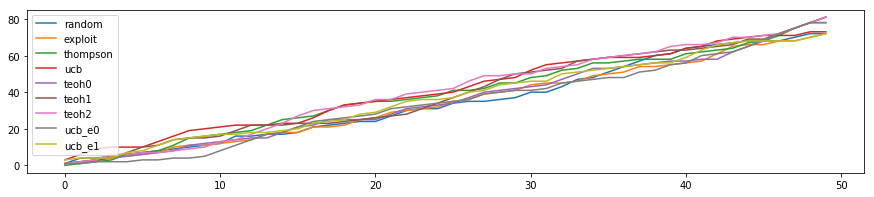

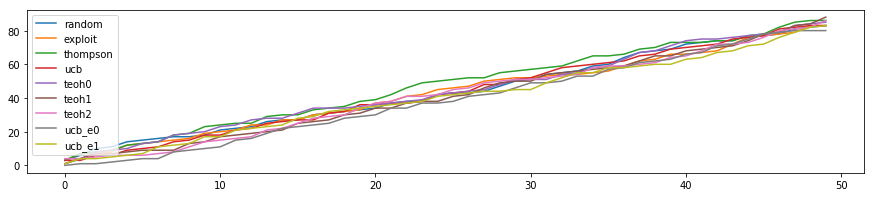

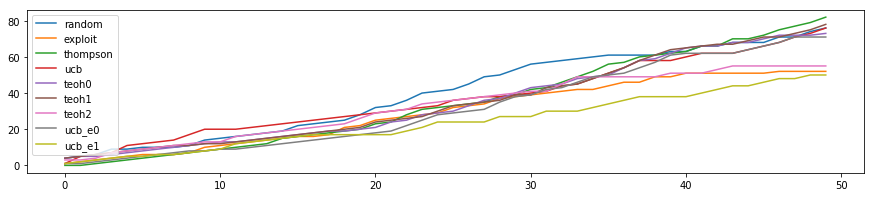

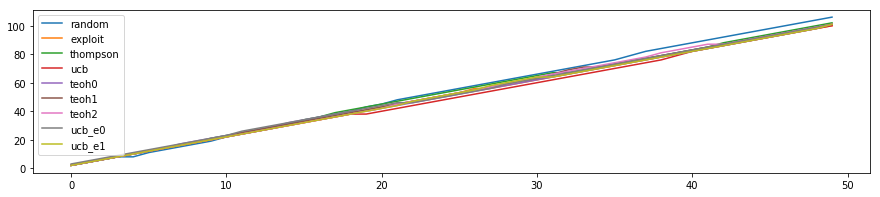

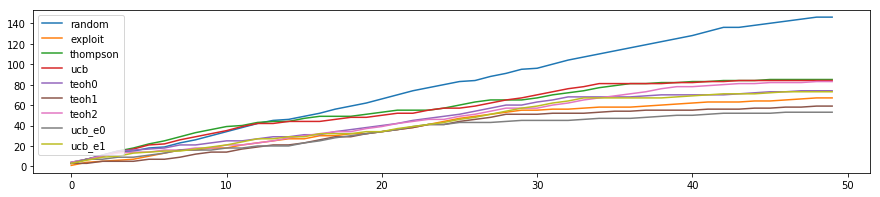

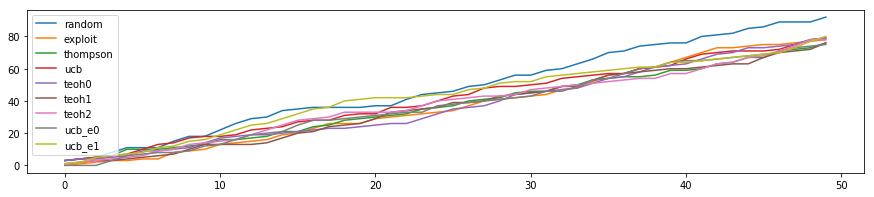

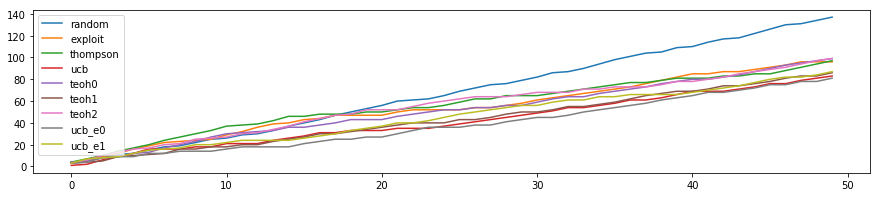

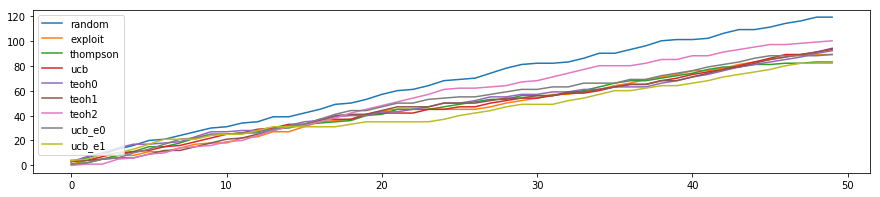

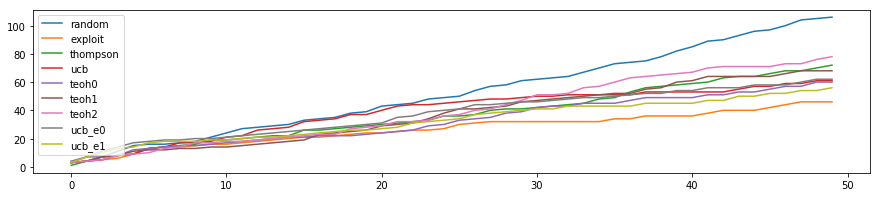

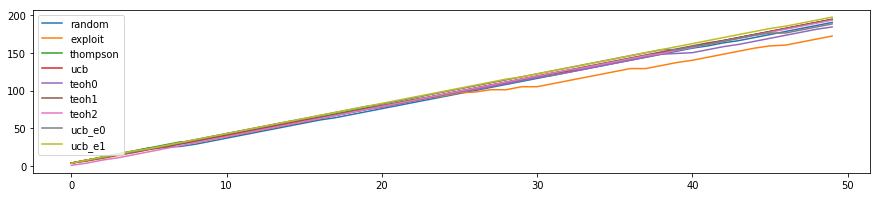

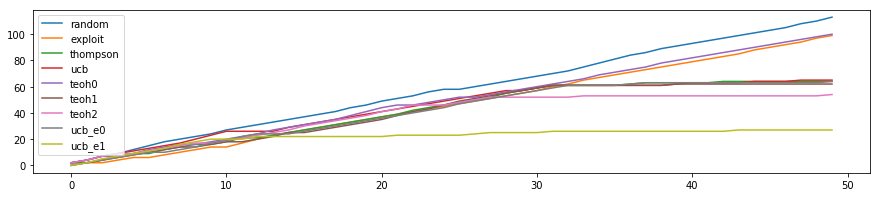

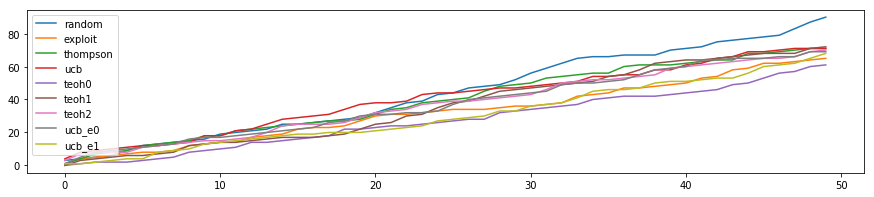

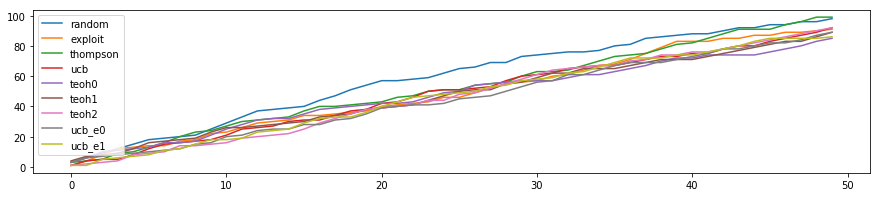

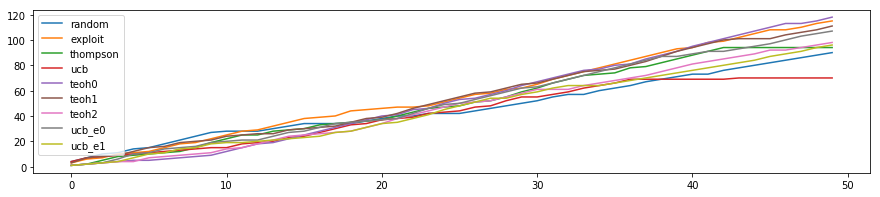

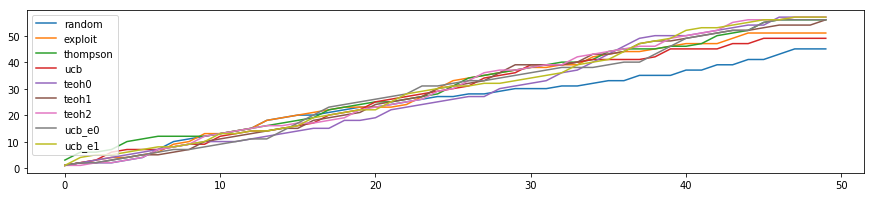

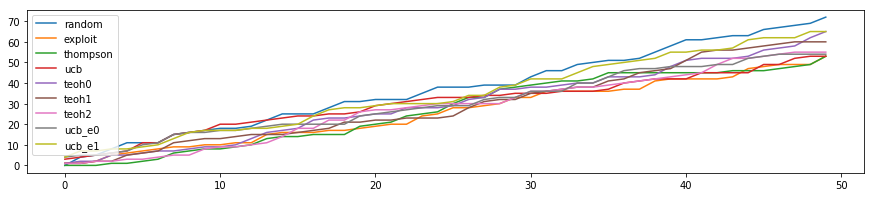

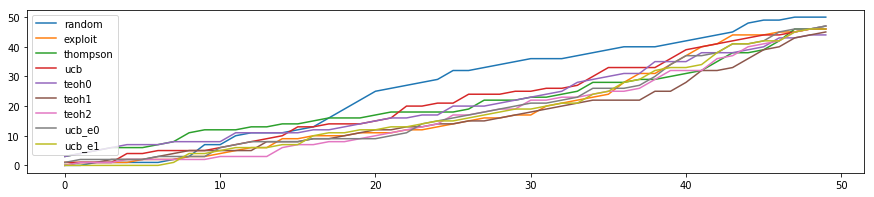

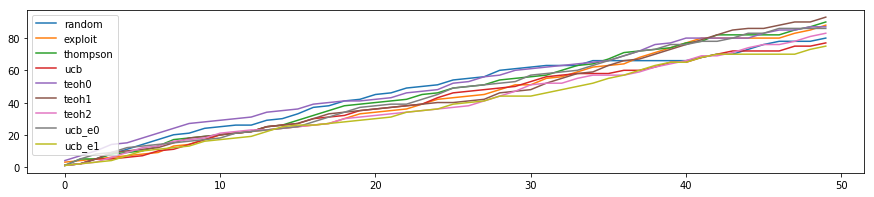

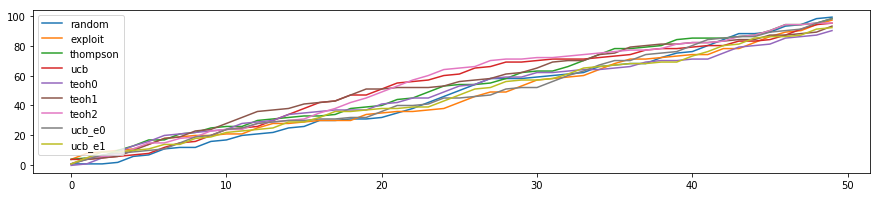

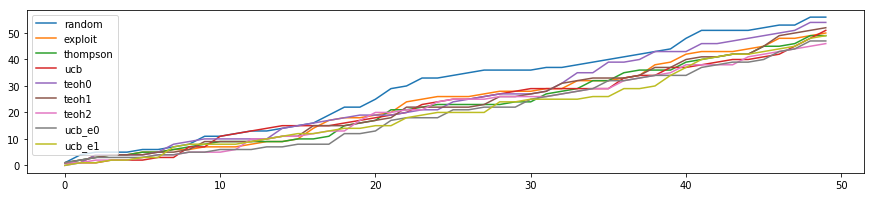

In [23]:
for _, user in dense_users:
    plt.plot(np.cumsum(dense_random[0][user]), label='random')
    plt.plot(np.cumsum(dense_exploit[0][user]), label='exploit')
    plt.plot(np.cumsum(dense_thompson[0][user]), label='thompson')
    plt.plot(np.cumsum(dense_ucb[0][user]), label='ucb')
    plt.plot(np.cumsum(dense_teoh0[0][user]), label='teoh0')
    plt.plot(np.cumsum(dense_teoh1[0][user]), label='teoh1')
    plt.plot(np.cumsum(dense_teoh2[0][user]), label='teoh2')
    plt.plot(np.cumsum(dense_ucb_e0[0][user]), label='ucb_e0')
    plt.plot(np.cumsum(dense_ucb_e1[0][user]), label='ucb_e1')
    
    plt.legend()
    plt.show()

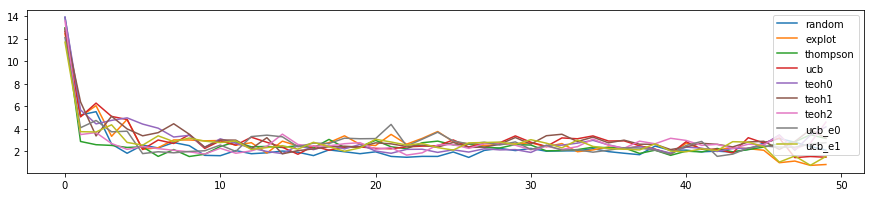

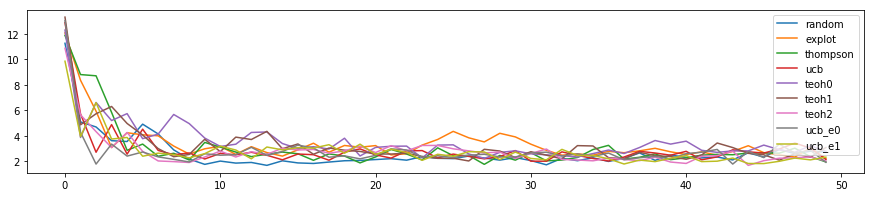

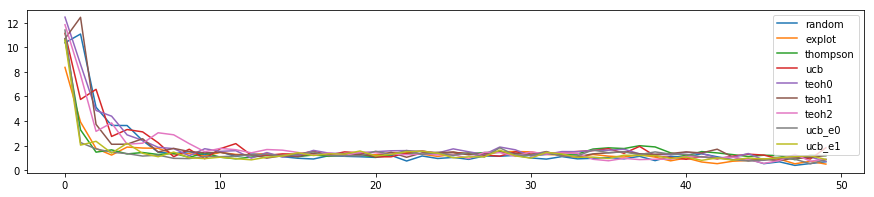

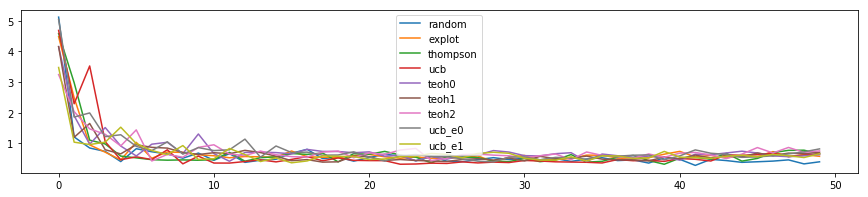

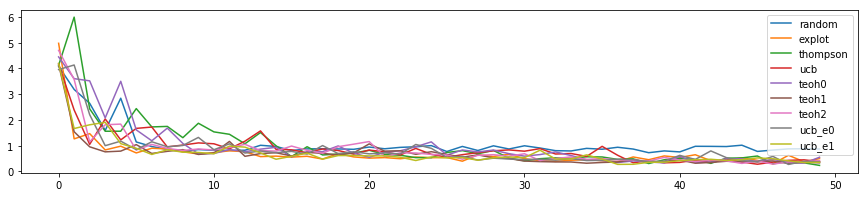

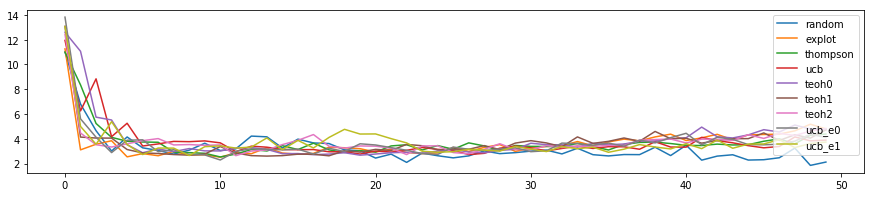

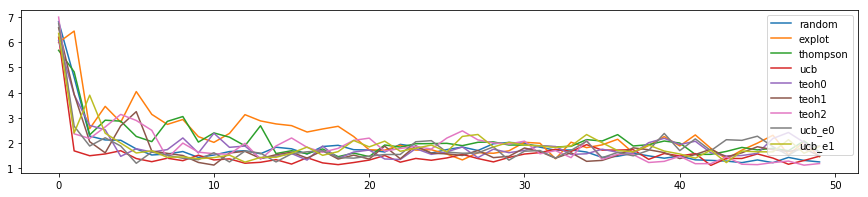

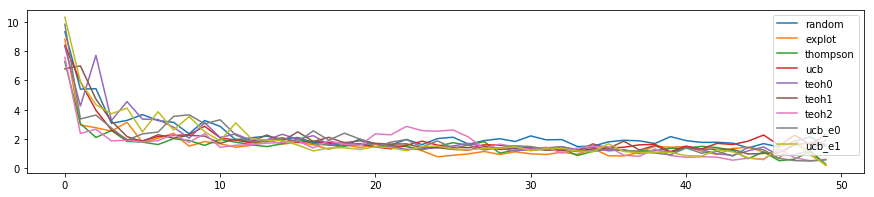

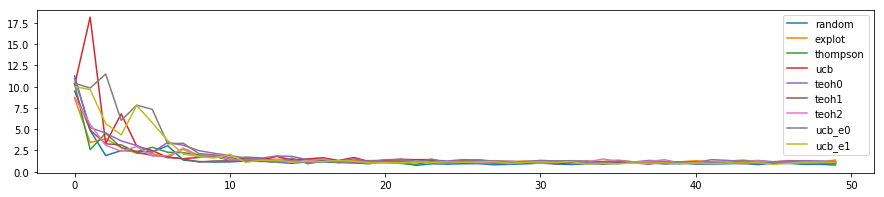

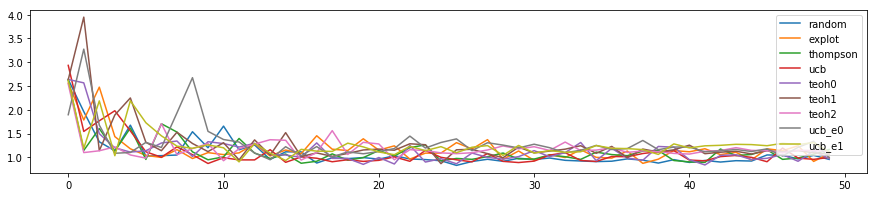

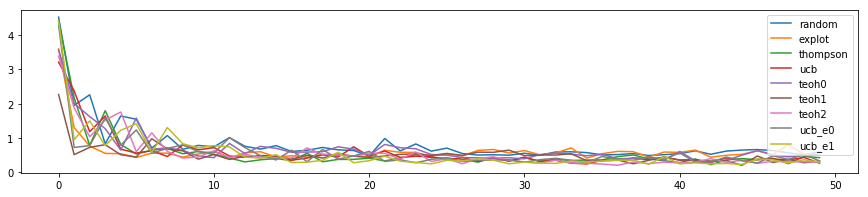

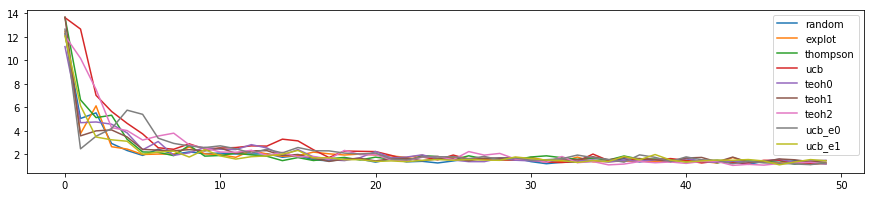

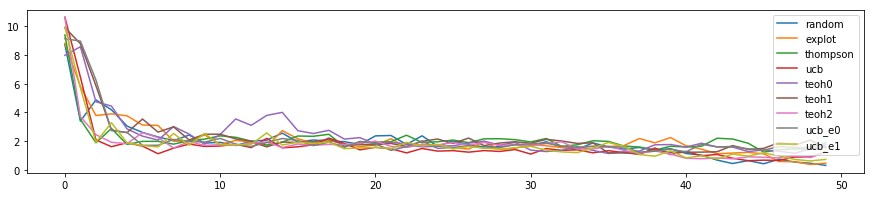

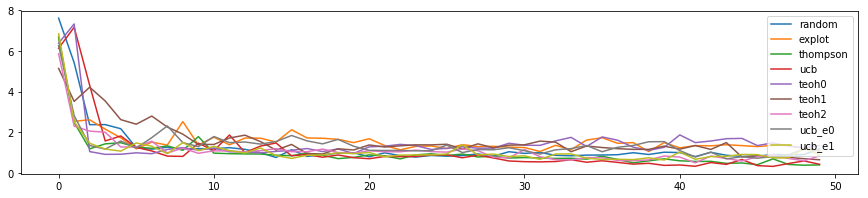

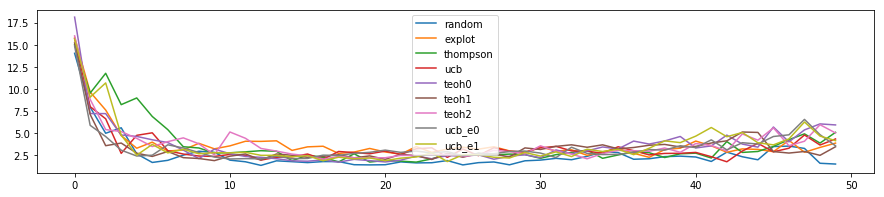

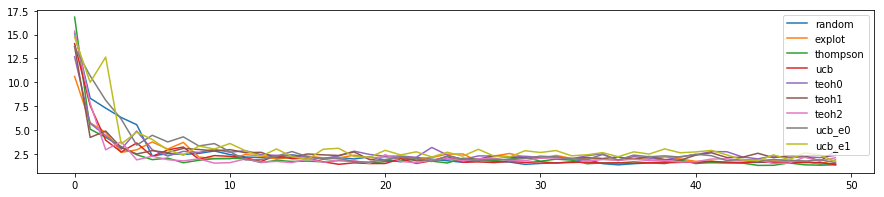

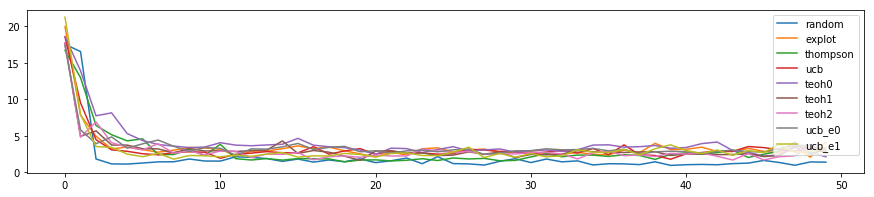

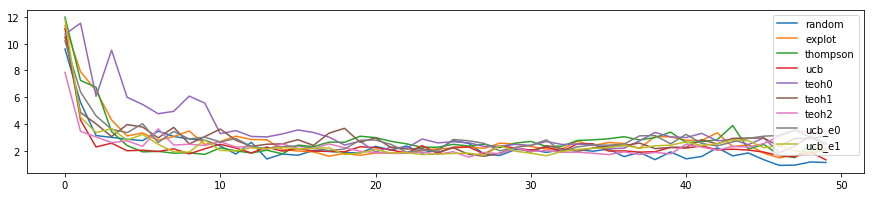

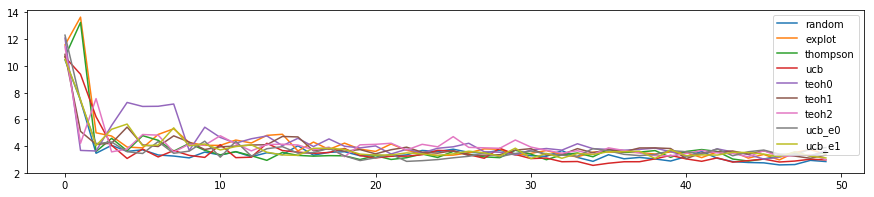

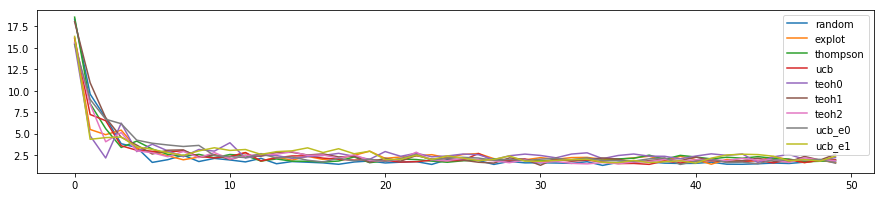

In [24]:
# Plot MSE change over time
labels = ['random', 'explot', 'thompson', 'ucb', 'teoh0', 'teoh1', 'teoh2', 'ucb_e0', 'ucb_e1']
for _,user in dense_users:
    for i in range(len(results)):
        plt.plot(results[i][1][user][0:], label=labels[i])
    plt.legend()
    plt.show()

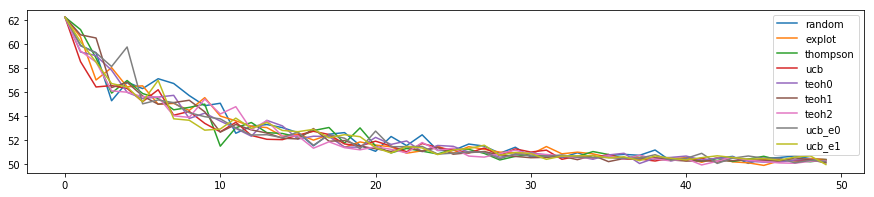

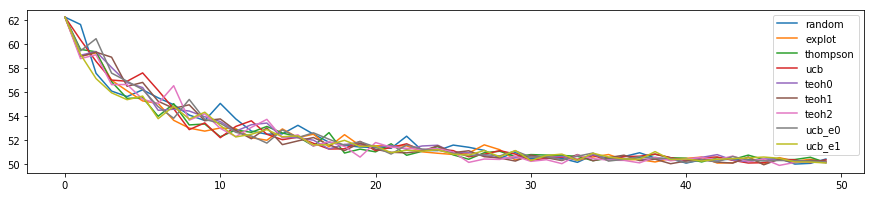

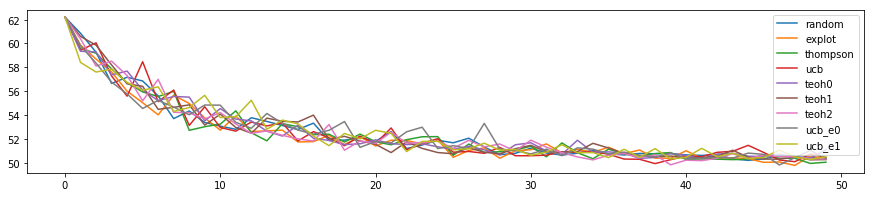

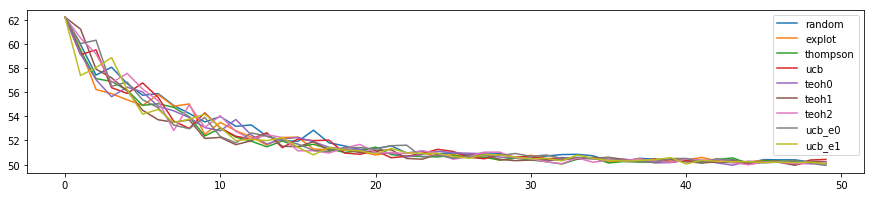

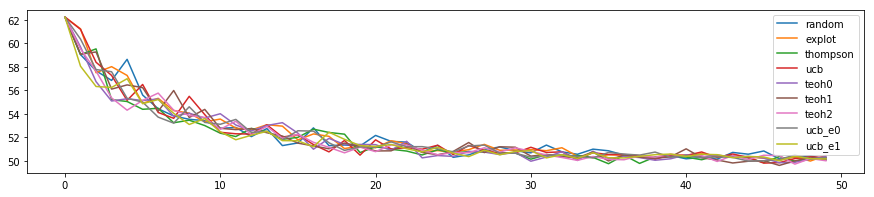

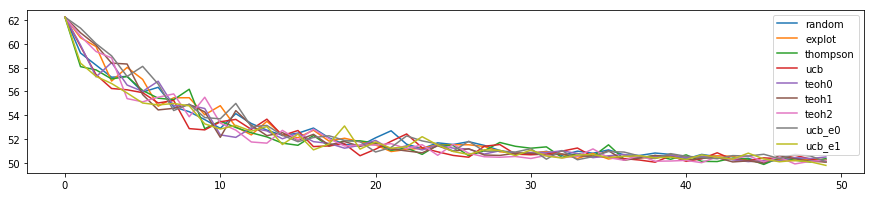

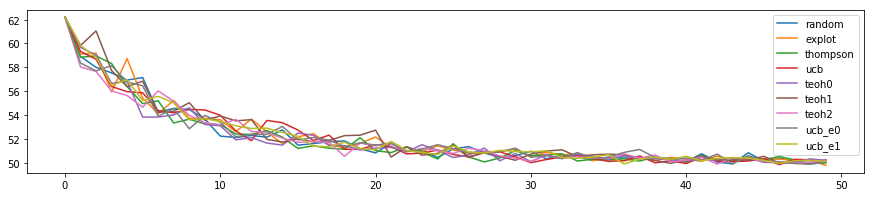

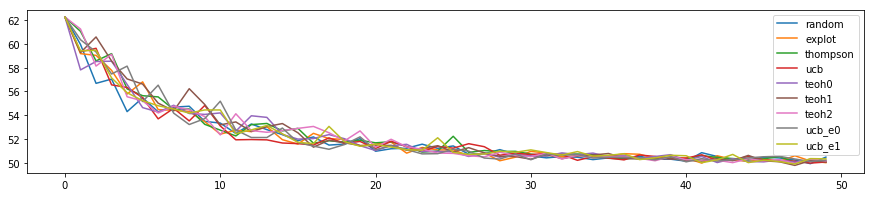

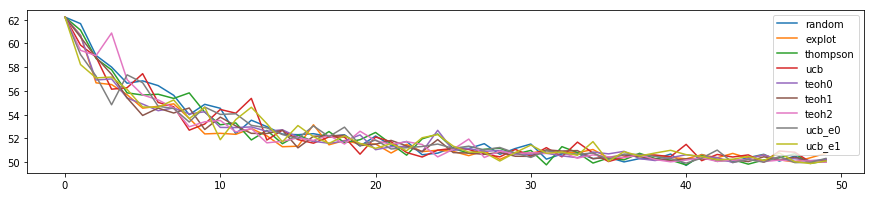

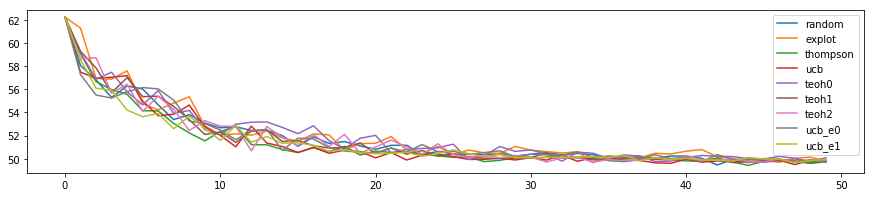

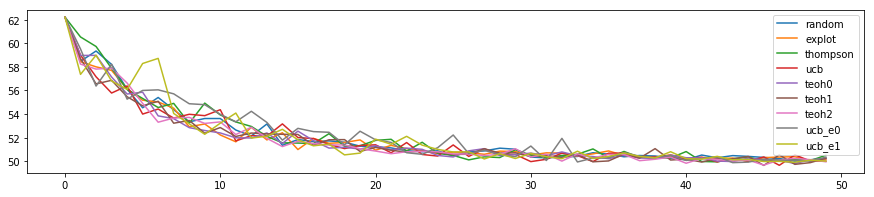

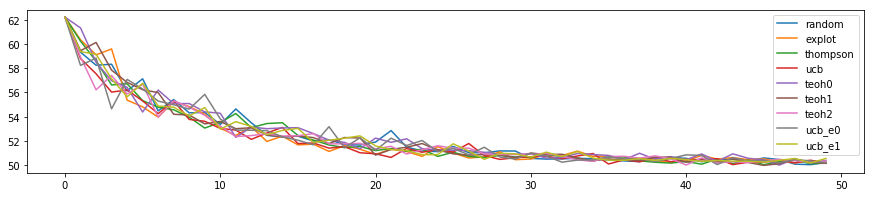

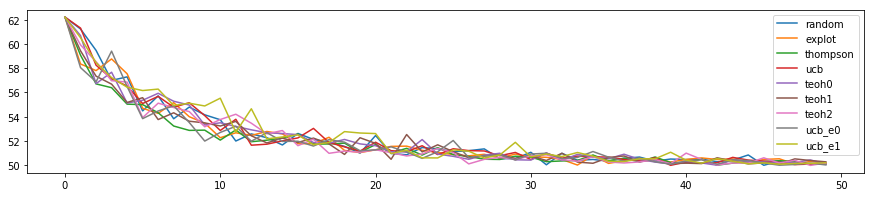

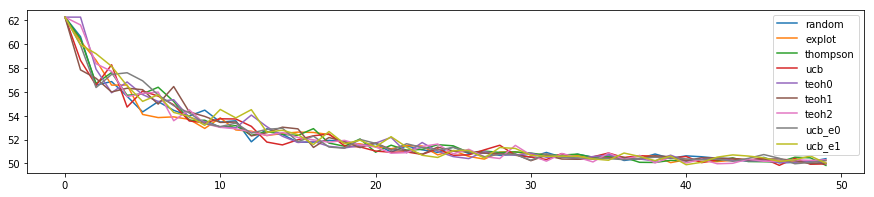

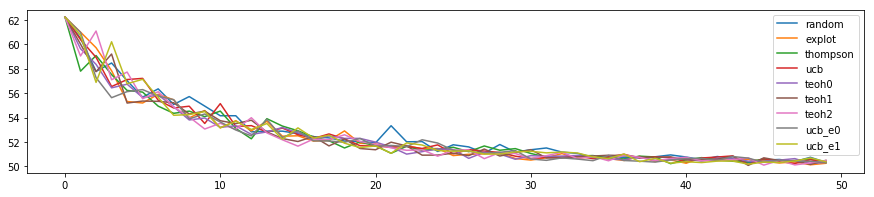

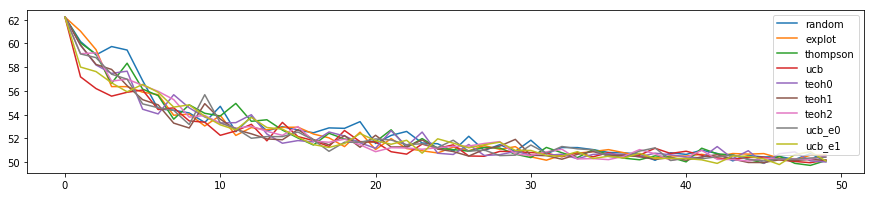

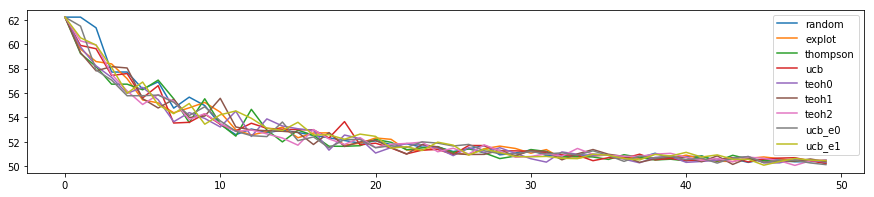

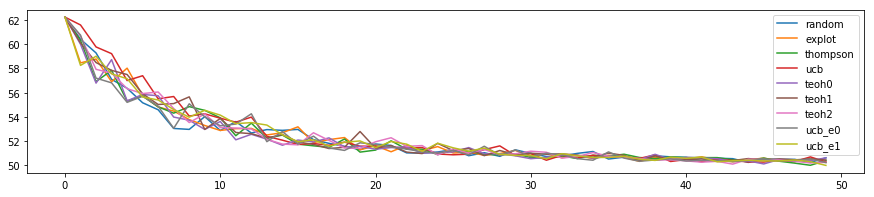

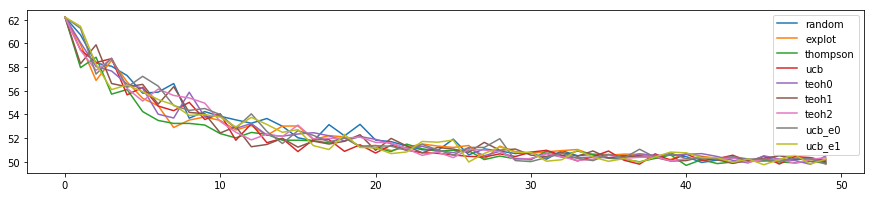

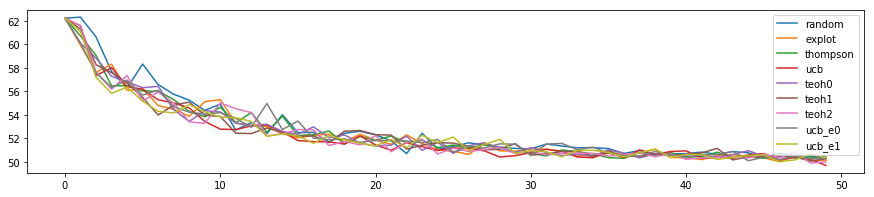

In [25]:
# Plot entropy change over time
labels = ['random', 'explot', 'thompson', 'ucb', 'teoh0', 'teoh1', 'teoh2', 'ucb_e0', 'ucb_e1']
for _,user in dense_users:
    for i in range(len(results)):
        plt.plot(results[i][2][user][0:], label=labels[i])
    plt.legend()
    plt.show()